# Capstone Part 1: Data Preprocessing and EDA

## Introduction

Emails are a huge part of any job. Whether it be research, corporate or even education, people use this technology to leave messages, some less important than others. Some have argued that emails are to become obsolete in the future, but evidence shows that email is here to stay for the foreseeable future. For example, IMs (instant messengers) might be faster, more wieldy, but there are so many of them out there now that it is difficult to keep track of which contact uses which IM.

Having said that, a [survey by Adobe](https://blog.adobe.com/en/publish/2019/09/08/if-you-think-email-is-dead--think-again.html#gs.f14pa9) have shown that employees spend a large amount of time on emails. The survey shows that the average email consumer spends about 3 hours a day on work email and 2 hours a day on personal email. 5 hours in a 24 hour day spent on email is definitely significant.
<img src='imgs/emailstats.jpg' alt='stats' width='500'/>
Granted, a portion of the time is spent on *reading* emails, but the other portion is spent writing them, and people have called writing emails "stressful" and "exhausting". They fear that writing too short an email reply might convey the wrong message ("thanks" or even "noted with thanks"), and they then ponder about the best way to go about crafting a reply that would not get them on the bad side of the wrong people.

Now just imagine how much more productive employees could be if something was to help them write parts of their email!

## Problem Statement

DBS has found that their employees have spent too much time on emails, in his opinion. They would like to implement some infrastructural aids so that employees can be more productive elsewhere. Email writing aids aren't the most novel idea in the world, with textexpander and Google's in-built Smart Compose features. 

However, the top brass at DBS's cybersecurity department have qualms about using third-party software in their infrastructure for security reasons. As a corporation holding loads of sensitive information and data, even the tiniest of risks could lead to a massive breach and leakage of personal information. 

Thus, the data science team has been tasked with building a email writing aid from scratch in the form of a word autocompleter or a text generator and see if it is ultimately worth implementing in their infrastructure.

## Executive Summary

This project explored data collected from the Enron email dataset, which served as the basis for a text generator based in the finance industry. This data was analyzed, cleaned and then preprocessed for usage in modelling.

We explored a few models in the journey to pick out the best one. First, we implemented a LSTM RNN model, training it with the base unclean data and established it as a base model. Next, we reran the same model but with the cleaned data. After that, we explored a pre-built transformers model (GPT-2) and finally we looked at a Markov Chains model for comparison. Ultimately, the GPT-2 model outperforms the rest, but there were several interesting quirks about the other models.

Finally, a cost benefit analysis was conducted to see if the model, if implemented, would bring about a sufficiently significant upside.

### Contents:
- [Data Preprocessing](#Data-Preprocessing)
- [EDA](#EDA)

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# sklearn libraries
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### Data Acquisition

Data that is used is shared by **[Brian Ray](https://data.world/brianray/enron-email-dataset).**

It is the Enron email dataset but converted from its original MIME format into a readable CSV format. The Enron email dataset contains approximately 500,000 emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission during its investigation of Enron's collapse.

Due to the massive size of the entire dataset, for time restraint reasons, only 17401 of the total 500000 will be used. (If time permits, maybe increase data to 100000 entries once final model decided)

In [9]:
df = pd.read_csv('dataset/enron6_original.csv')

## Data Preprocessing

The standard preprocessing methods for NLPs do not all apply to this task. For example, word tokenization might not be effective on a character based text generator while it may work for a word based text generator. Also, lowercasing might not be good as the distinction between words such as Apple (the company) and apple (the fruit) may be lost. This might lead to the meaning of the sentence being lost. However, for some modelling strategies these might be useful, so if required, these steps will be performed in their respective notebooks.

In [10]:
df.shape

(17401, 52)

In [11]:
df.columns

Index(['Unnamed: 0', 'Message-ID', 'Date', 'From', 'To', 'Subject', 'X-From',
       'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName',
       'content', 'user', 'Cat_1_level_1', 'Cat_1_level_2', 'Cat_1_weight',
       'Cat_2_level_1', 'Cat_2_level_2', 'Cat_2_weight', 'Cat_3_level_1',
       'Cat_3_level_2', 'Cat_3_weight', 'Cat_4_level_1', 'Cat_4_level_2',
       'Cat_4_weight', 'Cat_5_level_1', 'Cat_5_level_2', 'Cat_5_weight',
       'Cat_6_level_1', 'Cat_6_level_2', 'Cat_6_weight', 'Cat_7_level_1',
       'Cat_7_level_2', 'Cat_7_weight', 'Cat_8_level_1', 'Cat_8_level_2',
       'Cat_8_weight', 'Cat_9_level_1', 'Cat_9_level_2', 'Cat_9_weight',
       'Cat_10_level_1', 'Cat_10_level_2', 'Cat_10_weight', 'Cat_11_level_1',
       'Cat_11_level_2', 'Cat_11_weight', 'Cat_12_level_1', 'Cat_12_level_2',
       'Cat_12_weight', 'labeled'],
      dtype='object')

The data had been converted with a different purpose in mind, specifically for classification. This is why there are so many extra columns dealing with categories. These columns are irrelevant for the problem statement and thus will be discarded. Only the 'From', 'To', 'Subject' and 'content' columns will be kept.

In [12]:
df = df.loc[:, ['From', 'To', 'Subject', 'content']]

In [13]:
df.shape

(17401, 4)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17401 entries, 0 to 17400
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   From     17401 non-null  object
 1   To       15467 non-null  object
 2   Subject  17074 non-null  object
 3   content  17369 non-null  object
dtypes: object(4)
memory usage: 543.9+ KB


In [15]:
df.isnull().sum()

From          0
To         1934
Subject     327
content      32
dtype: int64

### Preprocessing - Missing Values
We can imput 0 for missing data quite confidently as this is not a classification task, so it should not affect the training nor the results.

In [16]:
df = df.fillna(0)

In [17]:
df.head()

,From,To,Subject,content
0,frozenset({'donna.fulton@enron.com'}),"frozenset({'david.fairley@enron.com', 'matt.lo...","RTO Orders - Grid South, SE Trans, SPP and Ent...",The Southeast RTO orders are out and have foll...
1,frozenset({'david.delainey@enron.com'}),"frozenset({'john.greg@enron.com', 'jeff.skilli...",More UC/CSU Info,---------------------- Forwarded by David W De...
2,frozenset({'jeff.dasovich@enron.com'}),"frozenset({'linda.robertson@enron.com', 'harry...",California Update 07.09.01,The Bond Legislation The Democrats in the Asse...
3,frozenset({'richard.shapiro@enron.com'}),"frozenset({'greg.whalley@enron.com', 'john.lav...",Davis & Company -- incompetence personified,FYI ---------------------- Forwarded by Richar...
4,frozenset({'richard.shapiro@enron.com'}),"frozenset({'greg.whalley@enron.com', 'john.lav...",Link to DWR contract info,FYI ---------------------- Forwarded by Richar...


### Preprocessing - Noise Removal for Character-Based LSTM Model
We try to get as comprehensive as possible a list of names from the 'From' and 'To' columns to be used as stopwords as we do not want the generator to be generating names.

In [18]:
def get_names(column):
    df[column] = df[
        column
    ].astype(
        str
    ).apply(
        lambda x: x.replace('frozenset({\'', '')
    ).apply(
        lambda x: x.replace('@enron.com', '')
    ).apply(
        lambda x: x.replace('\'})', '')
    ).apply(
        lambda x: x.replace('\'', '')
    ).apply(
        lambda x: x.split('.')
    )

In [19]:
get_names('From')
get_names('To')

In [20]:
def clean_list(col):
    x = df[col].sum()
    x = list(filter(('@').__ne__, x))
    x = [i.split(',', 1)[0] for i in x]
    x = [i.split('@',1)[0] for i in x]
    return x

In [21]:
stop_list_from = clean_list('From')
stop_list_to = clean_list('To')
stop_list_combined = set(stop_list_to + stop_list_from)
stop_list_combined = [i.capitalize() for i in stop_list_combined]

In [22]:
len(stop_list_combined)

6499

In [23]:
stop_list_combined = sorted(stop_list_combined, key=len)

In [24]:
stop_list_combined

['',
 '2',
 'R',
 'D',
 'J',
 '0',
 'F',
 'M',
 '>',
 'G',
 'H',
 'N',
 'A',
 'S',
 'E',
 'B',
 '-',
 'C',
 '1',
 'P',
 'V',
 'T',
 'L',
 'Y',
 'W',
 '6',
 'K',
 'Nu',
 'Qi',
 'Uk',
 'Ho',
 'Cn',
 'Go',
 'Ji',
 'Ca',
 'Ue',
 'Hq',
 'Af',
 'Ch',
 'M0',
 'Jr',
 'Bc',
 'Om',
 'Ng',
 'Xu',
 'Ae',
 'Ek',
 'Sk',
 'Kb',
 'Tx',
 'Cl',
 'Br',
 'Di',
 'Rr',
 'Hr',
 'Mu',
 '-2',
 'Pt',
 'Ic',
 'Cz',
 'At',
 'Dl',
 'Be',
 'Kr',
 'Uh',
 'Us',
 'Uu',
 'Yu',
 'Wu',
 'De',
 'Th',
 'Ii',
 'Co',
 'Ma',
 'Au',
 'Lo',
 'St',
 'Ed',
 'Do',
 'Cc',
 'Ku',
 'Ac',
 'Ta',
 'Bb',
 '-3',
 'Ru',
 'No',
 'Ly',
 'Sz',
 'Ab',
 'Su',
 'Es',
 'Se',
 'It',
 'Li',
 'Vu',
 'Jp',
 'Mx',
 'Dk',
 'Fr',
 'Nl',
 'Le',
 '26',
 'Oh',
 'Tk',
 '>"',
 'Ok',
 'Ha',
 'Or',
 'Hu',
 'Lu',
 'To',
 '-1',
 'Dr',
 'La',
 'Liz',
 'Coe',
 'Jim',
 'Jae',
 'Cox',
 'Soo',
 'Tow',
 'She',
 'Chu',
 'Pat',
 'Eng',
 'Boe',
 'Msn',
 'Van',
 'Wen',
 'Ifc',
 'Enw',
 'May',
 'Ahn',
 'Per',
 'La"',
 'Kam',
 'Pan',
 'Ev1',
 'Wax',
 'Fox',
 'Ray',
 'Les',

As we can see, the method is not perfect as there are many non-name strings in the list, but since majority of these words aren't true English words, it should suffice. We now remove any 2 character strings from the list in order to not affect the text too much. We also no longer need to From and To columns.

In [25]:
stop_list_combined = list(filter(lambda x: len (x) > 2, stop_list_combined))

In [26]:
df = df.drop(columns=['From', 'To'])

Now, we take a look at the content of the emails to see if there are any common noise that can be removed.

In [27]:
pd.set_option('display.max_colwidth', None)

In [28]:
df.head()

,Subject,content
0,"RTO Orders - Grid South, SE Trans, SPP and Entergy","The Southeast RTO orders are out and have followed through with what we exp= ected from the discussion at the FERC meeting. The SPP and Entergy RTO proposals have been rejected because they fail to s= atisfy the scope and configuration requirements of Order No. 2000. The Com= mission notes that the required discussions between SPP and Entergy and it= s neighboring RTO/TOs has led to no increase in the original scope and conf= iguration. The filings by SPP and Entergy were brief, indicating only a la= ck of interest by other RTOs or utilities in joining to enlarge scope; they= failed to specify any details of the talks, what changes could be made or = what could be fixed to accomodate combination with other RTOs. The order s= tates that the Commission favors the development of large, regional transmi= ssion organizations reflecting natural markets. The Commission indicates t= hat they favor four RTOs - NE, SE, MW and West. Therefore the order requir= es the participants in SPP and Entergy to participate in settlement discuss= ions as set out in the mediation order. Note that these meetings will star= t next Tuesday, July 17 before a FERC ALJ. The Southern Company RTO is also found by the FERC to fail the scope charac= teristics of Order No. 2000. The order finds that Southern's approach to f= ocus on MOUs and seams issues with its neighbors is inadequate. The order = states, ""We reiterate: the Commission's goal is to have a single RTO in the= Southeast, and to have that single RTO operational as soon as possible."" = The Commission recognizes that start-up costs in forming a larger RTO may b= e more, but that over the longer term, large RTOs will foster market develo= pment, will provide increased reliability and will result in lower wholesal= e electricity prices. The order therefore directs the parties to the media= tion as stated above. The Grid South participants are also directed to the mediation which is sta= rting on next Tuesday. It is a lengthier order with more details on other = aspects of RTOs, including Independent Board requirement, congestion managm= ent, interconnection procedures, planning process and CBM. Therefore, I am= attaching a summary of the order. One of the important findings of the or= der is that GridSouth is not sufficiently independent; the Applicant TOs ar= e making policy decisions that should be made by an independent board. The= refore, the order requires GridSouth to install an independent board and fi= le a compliance filing within 90 days. If anyone wants copies of the orders, let me know."
1,More UC/CSU Info,"---------------------- Forwarded by David W Delainey/HOU/EES on 07/12/2001 06:36 AM --------------------------- Dan Leff 07/11/2001 11:09 PM To: Marty Sunde/HOU/EES@EES, David W Delainey/HOU/EES@EES, Janet R Dietrich/HOU/EES@EES, Peggy Mahoney/HOU/EES@EES, Elizabeth Tilney/HOU/EES@EES, Vicki Sharp/HOU/EES@EES cc: Subject: More UC/CSU Info FYI - Dan AS uc enron agreement Jul. 11, 2001 Associated Press Newswires Copyright 2001. The Associated Press. All Rights Reserved. University of California, California State University and Enron Reach Settlement Agreement ATTENTION: State, Business editors OAKLAND, Calif., July 11 (AScribe News) -- The University of California, California State University and Enron Energy Services announced today a settlement agreement that will extend their contract for two years and return the two university systems to direct access service from Enron. As part of the agreement, UC and the CSU will drop their lawsuit against Enron and Enron will dismiss its appeal. The two university systems had brought suit in federal court seeking to retain their status as direct access Enron customers after Enron had resourced their power procurement to the Southern California Edison and Pacific Gas&Electric utility companies. ""We are delighted that our negotiations with Enron have ended with retention of

1. We notice that there are a lot of '= 's that seem to have replaced newlines when converted from MIME format to csv. We will remove all instances of these.


2. There is a lot of noise in the form of serial numbers (eg. APRS0119234206), phone numbers (eg. 713-345-7034), and such. We believe that removing all numerical characters should not post a problem in training for either text autocompletion or text generation as numbers do not contribute much to the context of a sentence. For example, "which range from a few months to 20 years" would become "which range from a few months to years". The sentence does not semantically change much, just that the detail of it being exactly 20 years is lost, and that is not too relevant to begin with.


3. Forwarded emails have a paragraph of noise. We will use regex to remove the entirety of the paragraph but slicing out the common text "Forwarded" all the way to "Subject".

There are still several issues, like typos and inconsistent noise like signatures and article credits and references. These will take a lot of manual processing as they do not have a discernible pattern, and thus will be left alone.

Text normalization was also considered (in which words like be4 would be normalized to before), but as Enron is a professional company, the language they used was also complete and did not contain many short-forms if at all.

Finally, stemming and lemmatization were also considered but ultimately eschewed as once again the distinction between different forms of the words are important in text prediction and generation. 

In [29]:
df['Subject'] = df['Subject'].astype(str)
df['content'] = df['content'].astype(str)

In [30]:
# resolving issue 1
df['content'] = df['content'].str.replace('= ', '', regex=True)

In [31]:
# resolving issue 2
p = re.compile(r'\d+')
df['content'] = [p.sub('', x) for x in df['content'].tolist()]

In [32]:
# resolving issue 3
df['content'] = df['content'].replace('Forwarded(.*)Subject:', '', regex=True)
df['content'] = df['content'].replace('Original(.*)Subject:', '', regex=True)

Finally, we remove the names compiled in the list of names so that the text predictor and generator will not give us names.

In [33]:
df['Subject'] = [' '.join([i for i in x.split() if i not in stop_list_combined]) for x in df['Subject']]

In [34]:
df['content'] = [' '.join([i for i in x.split() if i not in stop_list_combined]) for x in df['content']]

In [35]:
df['Subject'].head()

0    RTO - Grid South, SE Trans, SPP and Entergy
1                                    More UC/CSU
2                     California Update 07.09.01
3          & Company -- incompetence personified
4                           to DWR contract info
Name: Subject, dtype: object

In [36]:
df['content'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Southeast RTO orders are out and have followed through with what we expected from the discussion at the FERC meeting. SPP and Entergy RTO proposals have been rejected because they fail to satisfy the scope and configuration requirements of Order No. . Commission notes that the required discussions between SPP and Entergy and its neighboring RTO/TOs has led t

In [37]:
# df.to_csv('dataset/enron6_clean.csv', index=False)

In [41]:
# np.savetxt(r'enron6_clean.txt', df.values, fmt='%s')

## EDA

In [49]:
df = pd.read_csv('dataset/enron6_clean.csv')

In [50]:
df = df.fillna(str(0))

### N-grams Analysis

We want to look at n-grams as they will help to pick out strange words that occur at a high frequency, sufficiently so that they might affect the training of models later on.

In [54]:
def plot_ngram(df, col, stoplist, n1, n2):
    cvec = CountVectorizer(stop_words=stoplist, ngram_range=(n1, n2)) # instantiate
    vec_ = cvec.fit_transform(df[col]) # fit transform
    vec_df = pd.DataFrame(vec_.todense(),
                          columns=cvec.get_feature_names()) # convert to df
    x = vec_df.sum().sort_values(ascending=False).head(10).plot(kind='barh') # plot
    return x

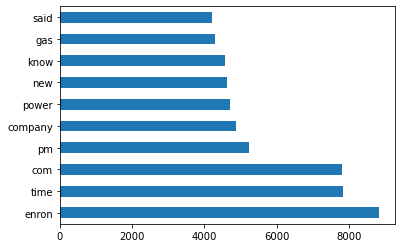

In [55]:
# getting unigram
plot_ngram(
    df,
    'content',
    'english',
    1,
    1
);

Nothing interesting here, Enron was a gas and power company so these words look fitting. Looking at it from a top-k perspective, we can hypothesize that these words will occur frequently in generated text that uses a top-k parameter (transformers for example).

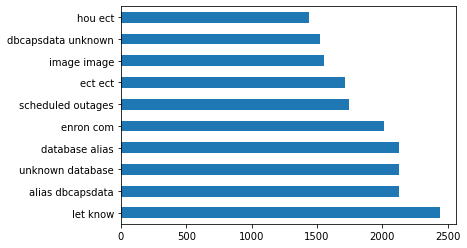

In [60]:
# getting bigram
plot_ngram(
    df,
    'content',
    'english',
    2,
    2
);

In [93]:
# trying to find database alias in text
df[df['content'].str.contains('database alias')].head(1)

,Subject,content
4277,FW: Enpower Notice ***THIS WEEKEND***,"FYI..if you have any shortcuts for Enpower applications on your desktop, you will need to change the path of the database from pwrprodn_ded to estpwrpn ----- Enpower Notice ***THIS WEEKEND*** Good Morning, To support the Estate / NETCO split, Enpower will be going down this weekend. at :pm Friday, th, we begin the process of moving databases & renaming them for the two companies. application is scheduled to be back online at :pm on Saturday, th. application team & any users volunteering for weekend testing will then begin performing some basic test scripts to ensure the applications still work. Please note that after the change, you will need to change any Excel Spreadsheets or Access Databases that connect to the ""PWRPRODN"" or ""PWRPRODN_DED"" database aliases to ""ESTPWRPN"". Thanks,"


In [86]:
# trying to find dbcapsdata in text
df[df['content'].str.contains('dbcapsdata')].head(1)

,Subject,content


In [87]:
# trying to find hou ect in text
df[df['content'].str.contains('hou ect')].head(1)

,Subject,content


Now there are strange phrases introduced. Database alias seems to be jargon that they use rather often. Hou, ect and  seem to be a by-product of the preprocessing and cvec processes and should be originally hour, etc, explaining why they are unable to be found in the actual text.

Dbcapsdata also cannot be found in the actual text, and I frankly cannot figure out why it exists.

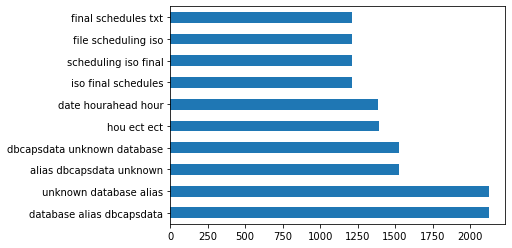

In [58]:
# getting trigram
plot_ngram(
    df,
    'content',
    'english',
    3,
    3
);

In [99]:
# trying to find final schedules in text
df[df['content'].str.contains('final schedules')].head(1)

Subject  \
10183  RE: California ISO Market Re-Design 2002 (MD02)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

The trigrams list look very similar to the bigrams list with the addition of schedules. Nothing out of the ordinary there, a financial company does work very often with schedules. ISO also refers to a market that deals in electricity which is relevant.

### Character Count

We use a character count and not a word count because there isn't any tokenization method that would reliably give us actual words due to the state of the data.

In [102]:
df['charlength'] = df['content'].apply(len)

In [109]:
df['charlength'].describe()

count    17401.000000
mean       960.034998
std       2325.929371
min          1.000000
25%        150.000000
50%        364.000000
75%        965.000000
max      91961.000000
Name: charlength, dtype: float64

''

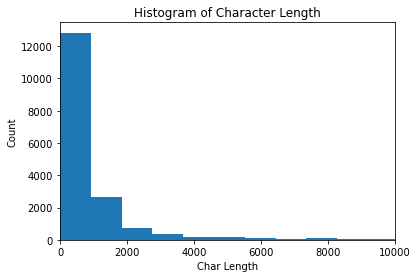

In [115]:
plt.hist(df['charlength'], bins=100)

plt.xlim(0, 10000)
plt.title('Histogram of Character Length')
plt.xlabel('Char Length')
plt.ylabel('Count')
;

Majority of the emails are short and in the 1000 characters range. Most of the emails above 10000 characters are newsletters and articles. We have considered dropping emails above 10000 characters, but we cannot rule out there being actual proper emails in the range as well. This might lead to the generated text sounding a bit article-ish but we will have to see.